# 序列模型


## 统计工具

处理序列数据需要统计工具和新的深度神经网络结构。为了简单起见，我们以 :numref:`fig_ftse100` 所示的股票价格（富时100指数）为例。

![近30年的富时100指数。](../img/ftse100.png)
:width:`400px`
:label:`fig_ftse100`

其中，用 $x_t$ 表示价格，即在 *时间步*（time step）$t \in \mathbb{Z}^+$时，观察到的价格 $x_t$。请注意，$t$ 对于本文中的序列通常是离散的，并随整数或其子集而变化。假设一个交易员想在 $t$ 日的股市中表现良好，于是通过以下途径预测 $x_t$：

$$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1).$$

### 自回归模型

为了实现这个预测，交易员可以使用回归模型，例如在 :numref:`sec_linear_concise` 中训练的模型。仅有一个主要问题：输入数据的数量，输入 $x_{t-1}, \ldots, x_1$ 本身因 $t$ 而异。也就是说，输入数据的数量这个数字将会随着我们遇到的数据量的增加而增加，因此需要一个近似方法来使这个计算变得容易处理。本章后面的大部分内容将围绕着如何有效估计 $P(x_t \mid x_{t-1}, \ldots, x_1)$ 展开。简单地说，它归结为以下两种策略。

第一种策略，假设在现实情况下相当长的序列 $x_{t-1}, \ldots, x_1$ 可能是不必要的，因此我们只需要满足某个长度为 $\tau$ 的时间跨度，即使用观测序列 $x_{t-1}, \ldots, x_{t-\tau}$。当下获得的最直接的好处就是参数的数量总是不变的，至少在 $t > \tau$ 时如此，这就使我们能够训练一个上面提及的深度网络。这种模型被称为 *自回归模型*（autoregressive models），因为它们就是对自己执行回归。

第二种策略，如 :numref:`fig_sequence-model` 所示，是保留一些对过去观测的总结 $h_t$，并且同时更新预测 $\hat{x}_t$ 和总结 $h_t$。这就产生了基于 $\hat{x}_t = P(x_t \mid h_{t})$ 估计 $x_t$，以及公式 $h_t = g(h_{t-1}, x_{t-1})$ 更新的模型。由于 $h_t$ 从未被观测到，这类模型也被称为 *隐变量自回归模型*（latent autoregressive models）。

![隐变量自回归模型](../img/sequence-model.svg)
:label:`fig_sequence-model`

这两种情况都有一个显而易见的问题，即如何生成训练数据。一个经典方法是使用到目前为止的历史观测来预测下一个未来观测。显然，我们并不指望时间会停滞不前。然而，一个常见的假设是虽然特定值 $x_t$ 可能会改变，但是序列本身的动力学不会改变。这样的假设是合理的，因为新的动力学一定受新的数据影响，而我们不可能用目前所掌握的数据来预测新的动力学。统计学家称不变的动力学为 *静止的*（stationary）。因此，无论我们做什么，整个序列的估计值都将通过以下的方式获得

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

注意，如果我们处理的是离散的对象（如单词），而不是连续的数字，则上述的考虑仍然有效。唯一的差别是，对于离散的对象，我们需要使用分类器而不是回归模型来估计 $P(x_t \mid  x_{t-1}, \ldots, x_1)$。

### 马尔可夫模型

回想一下，在自回归模型的近似法中，我们使用 $x_{t-1}, \ldots, x_{t-\tau}$ 而不是 $x_{t-1}, \ldots, x_1$ 来估计 $x_t$。只要这种近似是精确的，我们就说序列满足 *马尔可夫条件*（Markov condition）。特别是，如果 $\tau = 1$，得到一个 *一阶马尔可夫模型*（first-order Markov model），$P(x)$ 由下式给出：

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1).$$

当假设 $x_t$ 仅是离散值时，这样的模型特别棒，因为在这种情况下，使用动态规划可以沿着马尔可夫链精确地计算结果。例如，我们可以高效地计算$P(x_{t+1} \mid x_{t-1})$：

$$
\begin{aligned}
P(x_{t+1} \mid x_{t-1})
&= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})}\\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})}\\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{aligned}
$$

利用这一事实，我们只需要考虑过去观察中的一个非常短的历史：$P(x_{t+1} \mid x_t, x_{t-1}) = P(x_{t+1} \mid x_t)$。动态规划的详细介绍超出了本节的范围，而动态规划这些计算工具已经在控制算法和强化学习算法广泛使用。

### 因果关系

原则上，将 $P(x_1, \ldots, x_T)$ 倒序展开也没啥问题。毕竟，基于条件概率公式，我们总是可以写出：

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$

事实上，如果基于一个马尔可夫模型，我们还可以得到一个反向的条件概率分布。然而，在许多情况下，数据存在一个自然的方向，即在时间上是前进的。很明显，未来的事件不能影响过去。因此，如果我们改变 $x_t$，可能会影响未来发生的事情 $x_{t+1}$，但不能反过来。也就是说，如果我们改变 $x_t$，基于过去事件得到的分布不会改变。因此，解释 $P(x_{t+1} \mid x_t)$ 应该比解释 $P(x_t \mid x_{t+1})$ 更容易。例如，在某些情况下，对于某些可加性噪声 $\epsilon$，显然我们可以找到 $x_{t+1} = f(x_t) + \epsilon$，而反之则不行 :cite:`Hoyer.Janzing.Mooij.ea.2009` 。这是个好消息，因为这个前进方向通常也是我们感兴趣的方向。彼得斯等人写的这本书 :cite:`Peters.Janzing.Scholkopf.2017` 已经解释了关于这个主题的更多内容  ，而我们仅仅触及了它的皮毛。

## 训练

在回顾了这么多统计工具之后，让我们在实践中尝试一下。首先，生成一些数据。简单起见，我们(**使用正弦函数和一些可加性噪声来生成序列数据，时间步为 $1, 2, \ldots, 1000$。**)


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


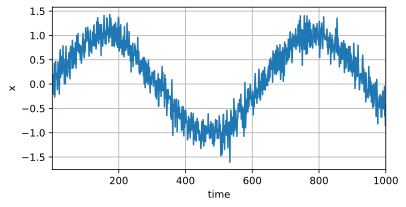

In [2]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们需要将这样的序列转换为模型可以训练的特征和标签。基于嵌入维度 $\tau$，我们[**将数据映射为数据对 $y_t = x_t$ 和 $\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$。**]精明的读者可能已经注意到，这比我们提供的数据样本少了 $\tau$ 个，因为我们没有足够的历史记录来描述前 $\tau$ 个数据样本。一个简单的解决办法，尤其是如果拥有足够长的序列就丢弃这几项；另一个方法，我们可以用零填充序列。在这里，我们仅使用前600个“特征－标签”（feature-label）对进行训练。


In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [4]:
batch_size, n_train = 16, 600
# 只有前`n_train`个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

在这里，训练模型[**使用一个相当简单的结构：只是一个拥有两个全连接层的多层感知机**]，ReLU激活函数和平方损失。


In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失
loss = nn.MSELoss()

现在，准备[**训练模型**]了。实现下面的训练代码的方式与前面几节（如 :numref:`sec_linear_concise` ）中的循环训练基本相同。因此，我们不会深入探讨太多细节。


In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.078043
epoch 2, loss: 0.056277
epoch 3, loss: 0.052731
epoch 4, loss: 0.050852
epoch 5, loss: 0.052064


## 预测

由于训练损失很小，因此我们期望模型能有很好的工作效果。让我们看看这在实践中意味着什么。首先是检查[**模型预测下一个时间步**]发生的是什么的能力，也就是 *单步预测*（one-step-ahead prediction）。


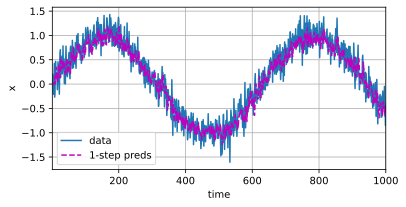

In [7]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

正如我们所料，单步预测效果不错。即使这些预测的时间步超过了 $600+4$（`n_train + tau`），其结果看起来仍然是可信的。然而有一个小问题：如果数据观察序列的时间步只到 $604$，那么我们就没办法指望能够得到所有未来的单步预测作为输入。相反，我们需要一步一步地向前迈进：
$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

通常，对于直到 $x_t$ 的观测序列，其在时间步 $t+k$ 处的预测输出 $\hat{x}_{t+k}$ 称为 *$k$ 步预测*（$k$-step-ahead-prediction）。由于我们的观察已经到了 $x_{604}$，它的 $k$ 步预测是 $\hat{x}_{604+k}$。换句话说，我们必须使用我们自己的预测（而不是原始数据）来[**进行多步预测**]。让我们看看效果如何。


In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

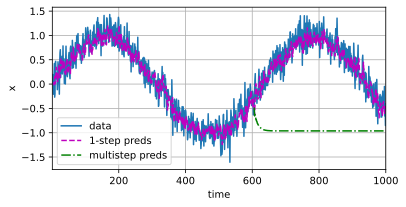

In [9]:
d2l.plot([time, time[tau:], time[n_train + tau:]], [
    x.detach().numpy(),
    onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x',
         legend=['data', '1-step preds',
                 'multistep preds'], xlim=[1, 1000], figsize=(6, 3))

如上面的例子所示，这是一个巨大的失败。经过几个预测步骤之后，预测的结果很快就会衰减到一个常数。为什么这个算法效果这么差呢？最终事实是由于错误的累积。假设在步骤 $1$ 之后，我们积累了一些错误 $\epsilon_1 = \bar\epsilon$。于是，步骤 $2$ 的 *输入*（input）被扰动了 $\epsilon_1$，结果积累的误差是依照次序的 $\epsilon_2 = \bar\epsilon + c \epsilon_1$，其中 $c$ 为某个常数，后面的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来 $24$ 小时的天气预报往往相当准确，但超过这一点，准确率就会迅速下降。我们将在本章及后续章节中讨论如何改进这一点。

基于 $k = 1, 4, 16, 64$，通过对整个序列预测的计算，让我们[**更仔细地看一下$k$步预测**]的困难。


In [10]:
max_steps = 64

In [11]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列 `i` (`i` < `tau`) 是来自 `x` 的观测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# 列 `i` (`i` >= `tau`) 是 (`i - tau + 1`)步的预测
# 其时间步从 `i + 1` 到 `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

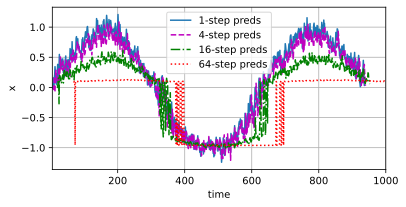

In [12]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))

# 文本预处理
:label:`sec_text_preprocessing`

对于序列数据处理问题，我们回顾和评估了使用的统计工具和预测时面临的挑战。
这样的数据存在许多种形式，文本是最常见例子之一。
例如，一篇文章可以简单地看作是一串单词序列，甚至是一串字符序列。
本节中，我们将专门解释文本的常见预处理步骤。
这些步骤通常包括：

1. 将文本作为字符串加载到内存中。
1. 将字符串拆分为词元（如单词和字符）。
1. 建立一个词汇表，将拆分的词元映射到数字索引。
1. 将文本转换为数字索引序列，方便模型操作。


In [1]:
import collections
import re
from d2l import torch as d2l

## 读取数据集

首先，我们从 H.G.Well 的[时光机器](http://www.gutenberg.org/ebooks/35)中加载文本。
这是一个相当小的语料库，只有30000多个单词，但足够我们小试牛刀，而现实中的文档集合可能会包含数十亿个单词。
下面的函数(**将数据集读取到由多条文本行组成的列表中**)，其中每条文本行都是一个字符串。
为简单起见，我们在这里忽略了标点符号和字母大写。


In [6]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
# 将字母以外的符号替换为空格
# re.sub：替换功能，第一个字符串是正则表达式，第二个是替换的字符串，第三个是要被处理的字符串
# ^：匹配输入字符串的开始位置，除非在方括号表达式中使用，当
# 该符号在方括号表达式中使用时，表示不接受该方括号表达式中的字符集合。
#  strip去除字符串头尾指定的字符（这里没用），lower使字母小写
lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 词元化

下面的 `tokenize` 函数将文本行列表作为输入，列表中的每个元素是一个文本序列（如一条文本行）。
[**每个文本序列又被拆分成一个词元列表**]，*词元*（token）是文本的基本单位。
最后，返回一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）。


In [11]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字母。"""
    if token == 'word':
        return [line.split() for line in lines]  # split以空格分割
    elif token == 'char':   # 将每个句子拆成一个个字母
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [9]:
tokens = tokenize(lines,token = "char")
for i in range(3):
    print(tokens[i])

['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'b', 'y', ' ', 'h', ' ', 'g', ' ', 'w', 'e', 'l', 'l', 's']
[]
[]


## 词汇表

词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。
现在，让我们[**构建一个字典，通常也叫做*词汇表*（vocabulary），用来将字符串类型的词元映射到从$0$开始的数字索引中**]。
我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计，得到的统计结果称之为*语料*（corpus）。
然后根据每个唯一词元的出现频率，为其分配一个数字索引。
很少出现的词元通常被移除，这可以降低复杂性。
另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元 “&lt;unk&gt;” 。
我们可以选择增加一个列表，用于保存那些被保留的词元，例如：填充词元（“&lt;pad&gt;”）；序列开始词元（“&lt;bos&gt;”）；序列结束词元（“&lt;eos&gt;”）。


In [24]:
class Vocab:  #@save
    """文本词汇表"""
    # min_freq为最小频率，如果频率大于最低频率则划分为特殊词元
    # reserved_tokens为保留字，划分为特殊词元
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 计算频率
        counter = count_corpus(tokens)
        # 按出现频率排序，这个lambda函数其实没用，从高到低
        # 结果为('the', 2261)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # 未知词元的索引为0，保留词元划分给特殊词元
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        
        # 如果频率大于最低频率则划分为特殊词元
        # 这里的+号感觉没有作用
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]  
        
        # 生成特殊词元的id到词元列表，词元到id字典
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):               # 是元组中的一个则返回True
            return self.token_to_idx.get(tokens,self.unk)       # 字典元素get查询，没有则返回默认值self.unk(0)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):  #@save
    """统计词元的频率。"""
    # 这里的 `tokens` 是 1D 列表或 2D 列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成使用词元填充的一个列表，即单个词的一维列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)   # 返回频率计数

In [25]:
vocab = Vocab(tokens)
vocab["dasda"]

0

In [15]:
sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243),
 ('for', 221),
 ('with', 216),
 ('but', 204),
 ('time', 200),
 ('were', 158),
 ('this', 152),
 ('you', 137),
 ('on', 137),
 ('then', 134),
 ('his', 129),
 ('there', 127),
 ('he', 123),
 ('have', 122),
 ('they', 122),
 ('from', 122),
 ('one', 120),
 ('all', 118),
 ('not', 114),
 ('into', 114),
 ('upon', 113),
 ('little', 113),
 ('so', 112),
 ('is', 106),
 ('came', 105),
 ('by', 103),
 ('some', 94),
 ('be', 93),
 ('no', 92),
 ('could', 92),
 ('their', 91),
 ('said', 89),
 ('saw', 88),
 ('down', 87),
 ('them', 86),
 ('machine', 85),
 ('which', 85),
 ('very', 85),
 ('or', 84),
 ('an', 84),
 ('we', 82),
 ('now', 79),
 ('what', 77),
 ('been', 75),
 ('these', 74),
 ('like', 74),
 ('her', 74),
 ('out', 73),
 ('seemed', 72),
 ('up', 71),
 ('man', 70),
 ('about', 70),
 ('s', 70),
 

我们首先使用时光机器数据集作为语料库来[**构建词汇表**]，然后打印前几个高频词元及其索引。


In [5]:
vocab = Vocab(tokens)
# 字典的items返回列表
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


现在，我们可以(**将每一条文本行转换成一个数字索引列表**)。


In [19]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## 整合所有功能

在使用上述函数时，我们[**将所有功能打包到`load_corpus_time_machine`函数中**]，该函数返回 `corpus`（词元索引列表）和 `vocab`（时光机器语料库的词汇表）。
我们在这里所做的改变是：
1. 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化；
2. 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的 `corpus` 仅处理为单个列表，而不是使用多个词元列表构成的一个列表。


In [29]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词汇表。"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'word')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line] # 返回的是词元索引值
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
# corpus是整本的语料库（索引值），vocab是语料库对象
corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(32775, 4580)

## 小结

* 文本是序列数据的一种重要形式。
* 为了对文本进行预处理，我们通常将文本拆分为词元，构建词汇表将词元字符串映射为数字索引，并将文本数据转换为词元索引以供模型操作。

## 练习

1. 词元化是一个关键的预处理步骤，它因语言而异，尝试找到另外三种常用的词元化文本的方法。
1. 在本节的实验中，将文本词元为单词和更改 `Vocab` 实例的 `min_freq` 参数。这对词汇量有何影响？


# 语言模型和数据集
:label:`sec_language_model`

在 :numref:`sec_text_preprocessing` 中，我们了解了如何将文本数据映射为词元，以及这些词元可以被视为一系列离散的观测，例如单词或字符。假设长度为 $T$ 的文本序列中的词元依次为 $x_1, x_2, \ldots, x_T$。于是，$x_t$($1 \leq t \leq T$) 可以被认为是文本序列在时间步 $t$ 处的观测或标签。在给定这样的文本序列时，*语言模型*（language model）的目标是估计序列的联合概率

$$P(x_1, x_2, \ldots, x_T).$$

语言模型是非常有用的。例如，只需要一次抽取一个词元 $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$，一个理想的语言模型就能够基于模型本身生成自然文本。与猴子使用打字机完全不同的是，从这样的模型中浮现的所有文本都将作为自然语言（例如，英语文本）来传递。此外，只需要基于前面的对话片断中的文本，就足以生成一个有意义的对话。显然，我们离设计出这样的系统还很遥远，因为它需要“理解”文本，而不仅仅是生成在语法上合理的内容。

尽管如此，语言模型依然是非常有用的，即使在它们受限的形式下。例如，短语“to recognize speech”和“to wreck a nice beach”听起来非常相似。这种相似性会导致语音识别中的歧义，但是这很容易通过语言模型来解决，因为第二种翻译的感觉很奇怪。同样，在文档摘要生成算法中，“狗咬人”比“人咬狗”出现的频率要高得多，或者“我想吃奶奶”是一个相当令人不安的语句，而“我想吃，奶奶”则要和蔼得多。

## 学习语言模型

显而易见，我们面对的问题是如何对一个文档，甚至是一个词元序列进行建模。假设在单词级别对文本数据进行词元化，我们可以依靠在 :numref:`sec_sequence` 中对序列模型的分析。让我们从基本概率规则开始：

$$P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^T P(x_t  \mid  x_1, \ldots, x_{t-1}).$$

例如，包含了四个单词的一个文本序列的概率是：

$$P(\text{deep}, \text{learning}, \text{is}, \text{fun}) =  P(\text{deep}) P(\text{learning}  \mid  \text{deep}) P(\text{is}  \mid  \text{deep}, \text{learning}) P(\text{fun}  \mid  \text{deep}, \text{learning}, \text{is}).$$

为了计算语言模型，我们需要计算单词的概率和给定前面几个单词后出现某个单词的条件概率。这些概率本质上就是语言模型的参数。

这里，我们假设训练数据集是一个大型的文本语料库，比如，所有维基百科的条目，[古登堡计划](https://en.wikipedia.org/wiki/Project_Gutenberg)，以及所有发布在网络上的文本。训练数据集中词的概率可以根据给定词的相对词频来计算。例如，可以将估计值 $\hat{P}(\text{deep})$ 计算为任何以单词“deep”开头的句子的概率。一种稍稍不太精确的方法是统计单词“deep”在数据集中的出现次数，然后将其除以整个语料库中的单词总数。这种方法效果不错，特别是对于频繁出现的单词。接下来，我们可以尝试估计

$$\hat{P}(\text{learning} \mid \text{deep}) = \frac{n(\text{deep, learning})}{n(\text{deep})},$$

其中 $n(x)$ 和 $n(x, x')$ 分别是单个单词和连续单词对的出现次数。不幸的是，由于连续单词对“deep learning”的出现频率要低得多，所以估计这类单词正确的概率要困难得多。特别是，对于一些不常见的单词组合，要想找到足够的出现次数来获得准确的估计可能都不容易。而对于三个或者更多单词的组合，情况会变得更糟。许多合理的三个单词组合可能是存在的，但是在数据集中却找不到。除非我们提供某种解决方案来将这些单词组合指定为非零计数，否则将无法在语言模型中使用它们。如果数据集很小，或者单词非常罕见，那么这类单词出现一次的机会可能都找不到。

一种常见的策略是执行某种形式的 *拉普拉斯平滑*（Laplace smoothing），具体方法是在所有计数中添加一个小常量。用 $n$ 表示训练集中的单词总数，用 $m$ 表示唯一单词的数量。此解决方案有助于处理单元素问题，例如通过：

$$
\begin{aligned}
    \hat{P}(x) & = \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
    \hat{P}(x' \mid x) & = \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
    \hat{P}(x'' \mid x,x') & = \frac{n(x, x',x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{aligned}
$$

其中，$\epsilon_1,\epsilon_2$ 和 $\epsilon_3$ 是超参数。以 $\epsilon_1$ 为例：当 $\epsilon_1 = 0$ 时，不应用平滑；当 $\epsilon_1$ 接近正无穷大时，$\hat{P}(x)$ 接近均匀概率分布 $1/m$。上面的公式是 :cite:`Wood.Gasthaus.Archambeau.ea.2011` 的其他技术实现方法的一个相当原始的变形。

不幸的是，像这样的模型很容易就会因为下面的原因变得无效：首先，我们需要存储所有的计数；其次，这完全忽略了单词的意思。例如，“猫”（cat）和“猫科动物”（feline）应该出现在相关的上下文中，但是想根据额外的上下文调整这些模型其实是相当困难的，然而基于深度学习的语言模型很适合解决这个问题。最后，长单词序列几乎可以肯定是没见过的，因此一个模型如果只是简单地统计先前看到的单词序列的频率，那么模型面对这种问题肯定是表现不佳的。

## 马尔可夫模型与$n$元语法

在讨论包含深度学习的解决方案之前，我们需要知道更多的概念和术语。回想一下我们在 :numref:`sec_sequence` 中对马尔可夫模型的讨论，并且将其应用于语言建模。如果 $P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，则序列上的分布满足一阶马尔可夫性质。阶数越高，对应的依赖关系就越长。这种性质推导出了许多可以应用于序列建模的近似公式：

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

通常，涉及一个、两个和三个变量的概率公式分别被称为“一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）模型。下面，我们将学习如何去设计更好的模型。

## 自然语言统计

让我们看看在真实数据上效果如何。根据 :numref:`sec_text_preprocessing` 中介绍的时光机器数据集构建词汇表，并打印前 $10$ 个最常用的（频率最高的）单词。


In [32]:
import random
import torch
from d2l import torch as d2l

In [34]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，事实上(**最流行的词**)看起来很无聊。这些词通常(**被称为*停用词***)（stop words），因此可以被过滤掉。尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。此外，还有个明显的问题是词频衰减的速度相当地快。例如，最常用单词的词频对比，第 $10$ 个还不到第 $1$ 个的 $1/5$。
为了更好地理解，我们可以[**画出的词频图**]。


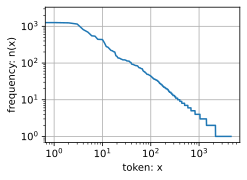

In [35]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log',
         yscale='log')

通过此图我们可以发现某些根本的东西：词频以一种明确的方式迅速衰减。将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。这意味着单词的频率满足 *齐普夫定律*（Zipf's law），即第 $i$ 个最常用单词的频率 $n_i$ 为：

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

等价于

$$\log n_i = -\alpha \log i + c,$$

其中 $\alpha$ 是刻画分布的指数，$c$ 是常数。这就告诉我们想要通过计数统计和平滑来建模单词是不可行的，这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。那么[**其他的词元组合，比如二元语法、三元语法等等，又会如何呢？**]让我们看看二元语法的频率是否与一元语法的频率表现出相同的行为方式。


In [26]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]   # 将两个列表组合起来，词元相差一个位置
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的，只有一个与“the time”有关。进一步，让我们看看三元语法的频率是否表现出相同的行为方式。


In [27]:
trigram_tokens = [
    triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，让我们[**直观地对比三种模型中的词元频率**]：一元语法、二元语法和三元语法。


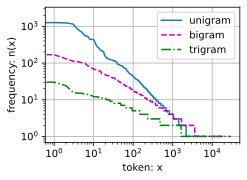

In [28]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

这张图令人激动的原因有很多。首先，除了一元语法词，单词序列似乎也遵循齐普夫定律，尽管公式 :eqref:`eq_zipf_law` 中的指数 $\alpha$ 更小（指数的大小受序列长度的影响）。其次，词汇表中 $n$ 元组的数量并没有那么大，这说明语言中存在相当多的结构，这些结构给了我们应用模型的希望。第三，很多 $n$ 元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。作为代替，我们将使用基于深度学习的模型。

## 读取长序列数据

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。在 :numref:`sec_sequence` 中我们以一种相当特别的方式做到了这一点。当序列变得太长而不能被模型一次性全部处理时，我们可能希望拆分这样的序列方便模型读取。现在让我们描述一下总体策略。在介绍该模型之前，假设我们将使用神经网络来训练语言模型，模型中的网络一次处理具有预定义长度（例如 $n$ 个时间步）的一个小批量序列。现在的问题是如何[**随机地生成一个小批量数据的特征和标签以供读取。**]

首先，由于文本序列可以是任意长的，例如整本《时光机器》(*The Time Machine*)，于是任意长的序列可以被我们划分为具有相同时间步数的子序列。当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。假设网络一次只处理具有 $n$ 个时间步的子序列。 :numref:`fig_timemachine_5gram` 画出了从原始文本序列获得子序列的所有不同的方式，其中 $n=5$，并且每个时间步的词元对应于一个字符。请注意，因为我们可以选择任意偏移量来指示初始位置，所以我们有相当大的自由度。

![分割文本时，不同的偏移量会导致不同的子序列。](../img/timemachine-5gram.svg)
:label:`fig_timemachine_5gram`

因此，我们应该从 :numref:`fig_timemachine_5gram` 中选择哪一个呢？事实上，他们都一样的好。然而，如果我们只选择一个偏移量，那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。因此，我们可以从随机偏移量开始划分序列，以同时获得 *覆盖性*（coverage）和 *随机性*（randomness）。下面，我们将描述如何实现 *随机采样*（random sampling）和 *顺序分区*（sequential partitioning）策略。

### 随机采样

(**在随机采样中，每个样本都是在原始的长序列上任意捕获的子序列。**)在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。**对于语言建模，目标是基于到目前为止我们看到的词元来预测下一个词元，因此标签是移位了一个词元的原始序列。**

下面的代码每次都从数据中随机生成一个小批量。在这里，参数 `batch_size` 指定了每个小批量中子序列样本的数目，参数 `num_steps` 是每个子序列中预定义的时间步数。


In [39]:
corpus

['the',
 'time',
 'machine',
 'by',
 'h',
 'g',
 'wells',
 'i',
 'the',
 'time',
 'traveller',
 'for',
 'so',
 'it',
 'will',
 'be',
 'convenient',
 'to',
 'speak',
 'of',
 'him',
 'was',
 'expounding',
 'a',
 'recondite',
 'matter',
 'to',
 'us',
 'his',
 'grey',
 'eyes',
 'shone',
 'and',
 'twinkled',
 'and',
 'his',
 'usually',
 'pale',
 'face',
 'was',
 'flushed',
 'and',
 'animated',
 'the',
 'fire',
 'burned',
 'brightly',
 'and',
 'the',
 'soft',
 'radiance',
 'of',
 'the',
 'incandescent',
 'lights',
 'in',
 'the',
 'lilies',
 'of',
 'silver',
 'caught',
 'the',
 'bubbles',
 'that',
 'flashed',
 'and',
 'passed',
 'in',
 'our',
 'glasses',
 'our',
 'chairs',
 'being',
 'his',
 'patents',
 'embraced',
 'and',
 'caressed',
 'us',
 'rather',
 'than',
 'submitted',
 'to',
 'be',
 'sat',
 'upon',
 'and',
 'there',
 'was',
 'that',
 'luxurious',
 'after',
 'dinner',
 'atmosphere',
 'when',
 'thought',
 'roams',
 'gracefully',
 'free',
 'of',
 'the',
 'trammels',
 'of',
 'precision',


In [33]:
corpus[random.randint(0, 10 - 1):]

['h',
 'g',
 'wells',
 'i',
 'the',
 'time',
 'traveller',
 'for',
 'so',
 'it',
 'will',
 'be',
 'convenient',
 'to',
 'speak',
 'of',
 'him',
 'was',
 'expounding',
 'a',
 'recondite',
 'matter',
 'to',
 'us',
 'his',
 'grey',
 'eyes',
 'shone',
 'and',
 'twinkled',
 'and',
 'his',
 'usually',
 'pale',
 'face',
 'was',
 'flushed',
 'and',
 'animated',
 'the',
 'fire',
 'burned',
 'brightly',
 'and',
 'the',
 'soft',
 'radiance',
 'of',
 'the',
 'incandescent',
 'lights',
 'in',
 'the',
 'lilies',
 'of',
 'silver',
 'caught',
 'the',
 'bubbles',
 'that',
 'flashed',
 'and',
 'passed',
 'in',
 'our',
 'glasses',
 'our',
 'chairs',
 'being',
 'his',
 'patents',
 'embraced',
 'and',
 'caressed',
 'us',
 'rather',
 'than',
 'submitted',
 'to',
 'be',
 'sat',
 'upon',
 'and',
 'there',
 'was',
 'that',
 'luxurious',
 'after',
 'dinner',
 'atmosphere',
 'when',
 'thought',
 'roams',
 'gracefully',
 'free',
 'of',
 'the',
 'trammels',
 'of',
 'precision',
 'and',
 'he',
 'put',
 'it',
 'to',

In [40]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列。"""
    
    # 从随机偏移量开始对序列进行分区，随机范围包括`num_steps - 1`
    corpus = corpus[random.randint(0, num_steps - 1):]
    
    # 减去1，是因为我们需要考虑标签，//是向下取整除
    # 子序列长度
    num_subseqs = (len(corpus) - 1) // num_steps
    
    # 长度为`num_steps`的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从`pos`位置开始的长度为`num_steps`的序列
        return corpus[pos:pos + num_steps]
    
    # 批次数量
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，`initial_indices`包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        # 返回数据和标签，这是一个、iterator
        yield torch.tensor(X), torch.tensor(Y)

让我们[**生成一个从 $0$ 到 $34$ 的序列**]。假设批量大小为 $2$ ，时间步数为 $5$，这意味着可以生成 $\lfloor (35 - 1) / 5 \rfloor= 6$ 个“特征－标签”子序列对。设置小批量大小为 $2$ 时，我们只能得到 $3$ 个小批量。


In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 9, 10, 11, 12, 13],
        [ 4,  5,  6,  7,  8]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]])
X:  tensor([[24, 25, 26, 27, 28],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34]])
X:  tensor([[19, 20, 21, 22, 23],
        [14, 15, 16, 17, 18]]) 
Y: tensor([[20, 21, 22, 23, 24],
        [15, 16, 17, 18, 19]])


### 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外，我们还可以[**保证两个相邻的小批量中的子序列在原始序列上也是相邻的**]。这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。


In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列。"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

基于相同的设置，通过顺序分区[**读取每个小批量的子序列的特征 `X` 和标签 `Y`**]。通过将它们打印出来可以注意到，迭代期间来自两个相邻的小批量中的子序列在原始序列中确实是相邻的。


In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


现在，我们[**将上面的两个采样函数包装到一个类中**]，以便稍后可以将其用作数据迭代器。


In [11]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器。"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

[**最后，我们定义了一个函数 `load_data_time_machine` ，它同时返回数据迭代器和词汇表**]，因此可以与其他带有 `load_data` 前缀的函数（如 :numref:`sec_fashion_mnist` 中定义的 `d2l.load_data_fashion_mnist` ）类似地使用。


In [12]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词汇表。"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter,
                              max_tokens)
    return data_iter, data_iter.vocab

## 小结

* 语言模型是自然语言处理的关键。
* $n$ 元语法，通过截断相关性，为处理长序列提供了一种实用的模型。
* 长序列存在一个问题，那就是它们很少出现或者从不出现。
* 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他的 $n$ 元语法。
* 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词组成的词组。
* 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。

## 练习

1. 假设训练数据集中有 $100,000$ 个单词。一个四元语法需要存储多少个词频和相邻多词频率？
1. 我们如何对一系列对话建模？
1. 一元语法、二元语法和三元语法的齐普夫定律的指数是不一样的，你能设法估计嘛？
1. 想一想读取长序列数据的其他方法？
1. 考虑一下我们用于读取长序列的随机偏移量。
    1. 为什么随机偏移量是个好主意？
    1. 它真的会在文档的序列上实现完美的均匀分布吗？
    1. 你要怎么做才能使分布更均匀？
1. 如果我们希望一个序列样本是一个完整的句子，那么这在小批量抽样中会带来怎样的问题？如何解决？


# 循环神经网络
:label:`sec_rnn`

在 :numref:`sec_language_model` 中，我们介绍了 $n$ 元语法模型，其中单词 $x_t$ 在时间步 $t$ 的条件概率仅取决于前面 $n-1$ 个单词。如果我们想将时间步 $t-(n-1)$ 之前的单词的可能产生的影响合并到 $x_t$ 上就需要增加 $n$，然而模型参数的数量也会随之呈指数增长，因为词表 $\mathcal{V}$ 需要存储 $|\mathcal{V}|^n$ 个数字，因此与其将 $P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$ 模型化，不如使用隐变量模型：

$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

其中 $h_{t-1}$ 是 *隐藏状态*（也称为隐藏变量），其存储了到时间步 $t-1$ 的序列信息。通常，可以基于当前输入 $x_{t}$ 和先前隐藏状态 $h_{t-1}$ 来计算时间步 $t$ 处的任何时间的隐藏状态：

$$h_t = f(x_{t}, h_{t-1}).$$
:eqlabel:`eq_ht_xt`

对于一个足够强大的函数 $f$（ :eqref:`eq_ht_xt` ），隐变量模型不是近似值。毕竟 $h_t$ 是可以仅仅存储到目前为止观察到的所有数据，然而这样的操作可能会使计算和存储的代价都变得昂贵。

回想一下，我们在 :numref:`chap_perceptrons` 中讨论过的具有隐藏单元的隐藏层。值得注意的是，隐藏层和隐藏状态指的是两个截然不同的概念。如上所述，隐藏层是在输入到输出的路径上以观测角度来理解的隐藏的层，而隐藏状态则是在给定步骤所做的任何事情以技术角度来定义的 *输入*，并且这些状态只能通过先前时间步的数据来计算。

*循环神经网络*（Recurrent neural networks， RNNs）是具有隐藏状态的神经网络。在介绍循环神经网络模型之前，我们首先回顾 :numref:`sec_mlp` 中介绍的多层感知机模型。

## 无隐藏状态的神经网络

让我们来看一看只有单隐藏层的多层感知机。设隐藏层的激活函数为 $\phi$。给定一个小批量样本 $\mathbf{X} \in \mathbb{R}^{n \times d}$，其中批量大小为 $n$，输入维度为 $d$，则隐藏层的输出 $\mathbf{H} \in \mathbb{R}^{n \times h}$ 通过下式计算：

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$
:eqlabel:`rnn_h_without_state`

在 :eqref:`rnn_h_without_state` 中，我们拥有的隐藏层权重参数为  $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$、偏置参数为 $\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，以及隐藏单元的数目为 $h$。因此求和时将应用广播机制（见 :numref:`subsec_broadcasting`）。接下来，将隐藏变量 $\mathbf{H}$ 用作输出层的输入。输出层由下式给出：

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，$\mathbf{O} \in \mathbb{R}^{n \times q}$ 是输出变量，$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$ 是权重参数，$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$ 是输出层的偏置参数。如果是分类问题，我们可以用 $\text{softmax}(\mathbf{O})$ 来计算输出类别的概率分布。

这完全类似于之前在 :numref:`sec_sequence` 中解决的回归问题，因此我们省略了细节。无需多言，只要可以随机选择“特征-标签”对，并且通过自动微分和随机梯度下降能够学习网络参数就可以了。

## 有隐藏状态的循环神经网络
:label:`subsec_rnn_w_hidden_states`

当我们有隐藏状态后，情况就完全不同了。让我们更详细地看看这个结构。

假设我们在时间步$t$有小批量输入$\mathbf{X}_t \in \mathbb{R}^{n \times d}$。换言之，对于$n$个序列样本的小批量，$\mathbf{X}_t$的每一行对应于来自该序列的时间步$t$处的一个样本。接下来，用$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$表示时间步$t$的隐藏变量。与多层感知机不同的是，我们在这里保存了前一个时间步的隐藏变量$\mathbf{H}_{t-1}$，并引入了一个新的权重参数$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$来描述如何在当前时间步中使用前一个时间步的隐藏变量。具体地说，当前时间步隐藏变量的计算由当前时间步的输入与前一个时间步的隐藏变量一起确定：

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$
:eqlabel:`rnn_h_with_state`

与 :eqref:`rnn_h_without_state` 相比， :eqref:`rnn_h_with_state` 多添加了一项$\mathbf{H}_{t-1} \mathbf{W}_{hh}$，从而实例化了 :eqref:`eq_ht_xt`。从相邻时间步的隐藏变量$\mathbf{H}_t$和$\mathbf{H}_{t-1}$之间的关系可知，这些变量捕获并保留了序列直到其当前时间步的历史信息，就如当前时间步下神经网络的状态或记忆，因此这样的隐藏变量被称为 *隐藏状态*（hidden state）。由于在当前时间步中隐藏状态使用的定义与前一个时间步中使用的定义相同，因此 :eqref:`rnn_h_with_state` 的计算是 *循环的*（recurrent）。于是基于循环计算的隐状态神经网络被命名为 *循环神经网络*（recurrent neural networks）。在循环神经网络中执行 :eqref:`rnn_h_with_state` 计算的层称为 *循环层*（recurrent layers）。

有许多不同的方法可以构建循环神经网络，由 :eqref:`rnn_h_with_state` 定义的隐藏状态的循环神经网络是非常常见的一种。对于时间步$t$，输出层的输出类似于多层感知机中的计算：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

循环神经网络的参数包括隐藏层的权重$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$和偏置$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，以及输出层的权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$。值得一提的是，即使在不同的时间步，循环神经网络也总是使用这些模型参数。因此，循环神经网络的参数开销不会随着时间步的增加而增加。

:numref:`fig_rnn` 展示了循环神经网络在三个相邻时间步的计算逻辑。在任意时间步$t$，隐藏状态的计算可以被视为：1、拼接当前时间步$t$的输入$\mathbf{X}_t$和前一时间步$t-1$的隐藏状态$\mathbf{H}_{t-1}$；2、将拼接的结果送入带有激活函数$\phi$的全连接层。全连接层的输出是当前时间步$t$的隐藏状态$\mathbf{H}_t$。在本例中，模型参数是$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接，以及$\mathbf{b}_h$的偏置，所有这些参数都来自 :eqref:`rnn_h_with_state`。当前时间步$t$的隐藏状态$\mathbf{H}_t$将参与计算下一时间步$t+1$的隐藏状态$\mathbf{H}_{t+1}$。而且$\mathbf{H}_t$还将送入全连接输出层用于计算当前时间步$t$的输出$\mathbf{O}_t$。

![具有隐藏状态的循环神经网络。](../img/rnn.svg)
:label:`fig_rnn`

我们刚才提到，隐藏状态中$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$的计算，相当于$\mathbf{X}_t$和$\mathbf{H}_{t-1}$的拼接与$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接的矩阵乘法。
虽然这个性质可以通过数学证明，但在下面我们只使用一个简单的代码片段来说明。首先，我们定义矩阵`X`、`W_xh`、`H`和`W_hh`，它们的形状分别为$(3，1)$、$(1，4)$、$(3，4)$和$(4，4)$。分别将`X`乘以`W_xh`，将`H`乘以`W_hh`，然后将这两个乘法相加，我们得到一个形状为$(3，4)$的矩阵。


In [1]:
import torch
from d2l import torch as d2l

In [41]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 4.5150,  0.9711, -3.9444,  0.4324],
        [-1.5496,  0.7249,  2.6532, -0.4063],
        [ 1.7345, -0.7782, -2.2477,  0.5991]])

现在，我们沿列（轴1）拼接矩阵`X`和`H`，沿行（轴0）拼接矩阵`W_xh`和`W_hh`。这两个拼接分别产生形状$(3, 5)$和形状$(5, 4)$的矩阵。再将这两个拼接的矩阵相乘，我们得到与上面相同形状$(3, 4)$的输出矩阵。


In [3]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.9190,  0.6322, -0.9464, -0.8718],
        [ 1.1929, -0.5516,  0.6043, -0.4856],
        [ 0.0740, -2.3689, -0.8636, -0.3431]])

In [42]:
torch.cat((X, H), 1)

tensor([[ 0.2462,  0.8967, -0.3702, -1.0344, -2.2179],
        [-0.4417, -0.0288,  0.0585,  0.5575,  0.8724],
        [ 0.2965,  0.0257,  0.4282, -0.6914, -0.0991]])

## 基于循环神经网络的字符级语言模型

回想一下 :numref:`sec_language_model` 中的语言模型，我们的目标是根据过去的和当前的词元预测下一个词元，因此我们将原始序列移位一个词元作为标签。Bengio等人首先提出使用神经网络进行语言建模 :cite:`Bengio.Ducharme.Vincent.ea.2003`。接下来，我们将说明如何使用循环神经网络来构建语言模型。设小批量大小为1，批量中的那个文本序列为"machine"。为了简化后续部分的训练，我们考虑使用 *字符级语言模型*（character-level language model），将文本词元化为字符而不是单词。 :numref:`fig_rnn_train` 演示了如何通过基于字符级语言建模的循环神经网络使用当前的和先前的字符预测下一个字符。

![基于循环神经网络的字符级语言模型。输入序列和标签序列分别为“machin”和“achine”。](../img/rnn-train.svg)
:label:`fig_rnn_train`

在训练过程中，我们对每个时间步的输出层的输出进行softmax操作，然后利用交叉熵损失计算模型输出和标签之间的误差。由于隐藏层中隐藏状态的循环计算， :numref:`fig_rnn_train` 中的第$3$个时间步的输出$\mathbf{O}_3$由文本序列“m”、“a”和“c”确定。由于训练数据中这个文本序列的下一个字符是“h”，因此第$3$个时间步的损失将取决于下一个字符的概率分布，而下一个字符是基于特征序列“m”、“a”、“c”和这个时间步的标签“h”生成的。

在实践中，我们使用的批量大小为$n>1$，每个词元都由一个$d$维向量表示。因此，在时间步$t$输入$\mathbf X_t$将是一个$n\times d$矩阵，这与我们在 :numref:`subsec_rnn_w_hidden_states` 中讨论的相同。

## 困惑度（Perplexity）
:label:`subsec_perplexity`

最后，让我们讨论如何度量语言模型的质量，这将在后续部分中用于评估基于循环神经网络的模型。一种方法是检查文本有多么令人惊讶。一个好的语言模型能够用高度准确的词元来预测我们接下来会看到什么。考虑一下由不同的语言模型给出的对短语"It is raining"的续写：

1. "It is raining outside"
1. "It is raining banana tree"
1. "It is raining piouw;kcj pwepoiut"

就质量而言，例$1$显然是最好的。这些词是合乎情理的，也在逻辑上是连贯的。虽然这个模型可能没有很准确地反映出后续词的语义（“in San Francisco”和“in winter”可能才是完美的合理扩展），但该模型已经能够捕捉到跟在后面的是哪类单词。例$2$则要糟糕得多，因为其产生了一个无意义的续写。尽管如此，至少该模型已经学会了如何拼写单词以及单词之间的某种程度的相关性。最后，例$3$表明了训练不足的模型是无法正确地拟合数据。

我们可以通过计算序列的似然概率来度量模型的质量。不幸的是，这是一个难以理解，也难以比较较的数字。毕竟，较短的序列比较长的序列更有可能出现，因此评估模型产生托尔斯泰的巨著《战争与和平》的可能性不可避免地会比产生圣埃克苏佩里的中篇小说《小王子》可能性要小得多。而缺少的可能性值相当于平均数。

在这里，信息论可以派上用场了。我们在引入softmax回归（ :numref:`subsec_info_theory_basics` ）时定义了熵、惊奇和交叉熵，并在[信息论的在线附录](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html)中讨论了更多的信息论知识。如果想要压缩文本，我们可以询问根据当前词元集预测的下一个词元。一个更好的语言模型应该能让我们更准确地预测下一个词元。因此，它应该允许我们在压缩序列时花费更少的比特。所以我们可以通过一个序列中所有的$n$个词元的交叉熵损失的平均值来衡量：

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$
:eqlabel:`eq_avg_ce_for_lm`

其中$P$由语言模型给出，$x_t$是在时间步$t$从该序列中观察到的实际词元。这使得不同长度的文档的性能具有了可比性。由于历史原因，自然语言处理的科学家更喜欢使用一个叫做 *困惑度*（perplexity）的量。简而言之，它是 :eqref:`eq_avg_ce_for_lm` 的指数：

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

当我们决定下一个词元是哪个时，困惑度的最好的理解可以是下一个词元的实际选择数的调和平均数。让我们看看一些案例：

* 在最好的情况下，模型总是完美地估计标签词元的概率为1。在这种情况下，模型的困惑度为1。
* 在最坏的情况下，模型总是预测标签词元的概率为0。在这种情况下，困惑度是正无穷大。
* 在基线上，该模型的预测是词汇表的所有可用词元上的均匀分布。在这种情况下，困惑度等于词汇表中唯一词元的数量。事实上，如果我们在没有任何压缩的情况下存储序列，这将是我们能做的最好的编码方式。因此，这种方式提供了一个重要的上限，而任何实际模型都必须超越这个上限。

在接下来的章节中，我们将基于循环神经网络实现字符级语言模型，并使用困惑度来评估这样的模型。

## 小结

* 对隐藏状态使用循环计算的神经网络称为循环神经网络（RNN）。
* 循环神经网络的隐藏状态可以捕获直到当前时间步的序列的历史信息。
* 循环神经网络模型的参数数量不会随着时间步的增加而增加。
* 我们可以使用循环神经网络创建字符级语言模型。
* 我们可以使用困惑度来评价语言模型的质量。

## 练习

1. 如果我们使用循环神经网络来预测文本序列中的下一个字符，那么任意输出所需的维度是什么？
1. 为什么循环神经网络可以基于文本序列中所有先前的词元，在某个时间步表示当前词元的条件概率？
1. 如果你基于一个长序列进行反向传播，梯度会发生什么状况？
1. 与本节中描述的语言模型相关的问题有哪些？


# 循环神经网络的简洁实现
:label:`sec_rnn-concise`

虽然 :numref:`sec_rnn_scratch` 对了解循环神经网络的实现方式具有指导意义，但并不方便。本节将展示如何使用深度学习框架的高级API提供的函数更有效地实现相同的语言模型。我们仍然从读取时光机器数据集开始。


In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35   # 批量数和每个向量的字符长度
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**定义模型**]

高级API提供了循环神经网络的实现。我们构造了一个具有256个隐藏单元的单隐藏层的循环神经网络层 `rnn_layer`。事实上，我们还没有讨论多层的意义——这将在 :numref:`sec_deep_rnn`中介绍。现在，仅需要将多层理解为一层循环神经网络的输出被用作下一层循环神经网络的输入就足够了。


In [4]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

我们(**使用张量来初始化隐藏状态**)，它的形状是（隐藏层数，批量大小，隐藏单元数）。


In [5]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

[**通过一个隐藏状态和一个输入，我们就可以用更新后的隐藏状态计算输出。**]需要强调的是，`rnn_layer`的“输出”（`Y`）不涉及输出层的计算：它是指每个时间步的隐藏状态，这些隐藏状态可以用作后续输出层的输入。


In [6]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

与 :numref:`sec_rnn_scratch` 类似，[**我们为一个完整的循环神经网络模型定义了一个`RNNModel`类**]。注意， `rnn_layer` 只包含隐藏的循环层，我们还需要创建一个单独的输出层。


In [7]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），`num_directions`应该是2，否则应该是1。
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        # long() 函数将数字或字符串转换为一个长整型。
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        # 前向
        Y, state = self.rnn(X, state)
        # 全连接层首先将`Y`的形状改为(`时间步数`*`批量大小`, `隐藏单元数`)。
        # 它的输出形状是 (`时间步数`*`批量大小`, `词表大小`)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` 以张量作为隐藏状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens), device=device)
        else:
            # `nn.LSTM` 以张量作为隐藏状态
            return (torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device),
                    torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device))

## 训练与预测

在训练模型之前，让我们[**基于一个具有随机权重的模型进行预测**]。


In [8]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellertapppppppp'

很明显，这种模型根本不能输出好的结果。接下来，我们使用 :numref:`sec_rnn_scratch` 中定义的超参数调用 `train_ch8`，并且[**使用高级API训练模型**]。


perplexity 1.3, 255988.9 tokens/sec on cuda:0
time travellerit s against and langl the other wayoh this began 
travelleryou can some callexpof hos hit saolexustincenons o


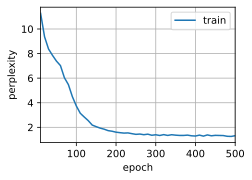

In [9]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

与上一节相比，由于深度学习框架的高级API对代码进行了更多的优化，该模型在较短的时间内实现了较低的困惑度。

## 小结

* 深度学习框架的高级API提供了循环神经网络层的实现。
* 高级API的循环神经网络层返回一个输出和一个更新后的隐藏状态，这个输出不涉及输出层的计算。
* 使用高级API实现的循环神经网络相比从零开始实现可以得到更快的训练速度。

## 练习

1. 你能使用高级API使循环神经网络模型过拟合吗？
1. 如果在循环神经网络模型中增加隐藏层的数量会发生什么？你能使模型正常工作吗？
1. 使用循环神经网络实现 :numref:`sec_sequence` 的自回归模型。


# 循环神经网络的从零开始实现
:label:`sec_rnn_scratch`

在本节中，我们将根据 :numref:`sec_rnn` 中的描述，从头开始基于循环神经网络实现字符级语言模型。这样的模型将在 H. G. Wells 的时光机器数据集上训练。和前面 :numref:`sec_language_model` 中介绍过的一样，我们先读取数据集。


In [11]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [12]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## [**独热编码**]

回想一下，在 `train_iter` 中，每个词元都表示为一个数字索引。将这些索引直接输入神经网络可能会使学习变得困难。我们通常将每个词元表示为更具表现力的特征向量。最简单的表示称为*独热编码*（one-hot encoding），它在 :numref:`subsec_classification-problem` 中介绍过。

简言之，将每个索引映射为相互不同的单位向量：假设词汇表中不同词元的数目为$N$（即 `len(vocab)`），词元索引的范围为$0$到$N-1$。如果词元的索引是整数$i$，那么我们创建一个长度为$N$的全$0$向量，并将第$i$处的元素设置为$1$。此向量是原始词元的一个独热向量。索引为$0$和$2$的独热向量如下所示。


len(vocab)不是词元的长度，而是词元的数量a-z加上特殊

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [50]:
len(vocab)

28

我们每次采样的(**小批量数据形状是（批量大小, 时间步数）。**) `one_hot`函数将这样一个小批量数据转换成三维张量，张量的最后一个维度等于词汇表大小（`len(vocab)`）。我们经常转换输入的维度，以便获得形状为（时间步数, 批量大小, 词汇表大小）的输出。这将使我们能够更方便地通过最外层的维度，一步一步地更新小批量数据的隐藏状态。


In [8]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [9]:
F.one_hot(X.T, 28)[0][0]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

## 初始化模型参数

接下来，我们[**初始化循环神经网络模型的模型参数**]。隐藏单元数`num_hiddens`是一个可调的超参数。当训练语言模型时，输入和输出来自相同的词汇表。因此，它们具有相同的维度，即词汇表的大小。


In [10]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## 循环神经网络模型

为了定义循环神经网络模型，我们首先需要[**一个`init_rnn_state`函数在初始化时返回隐藏状态**]。函数的返回是一个张量，张量全用0填充，形状为（批量大小, 隐藏单元数）。在后面的章节中将会遇到隐藏状态包含多个变量的情况，而使用元组可以处理地更容易些。


In [13]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

[**下面的`rnn`函数定义了如何在一个时间步内计算隐藏状态和输出。**]请注意，循环神经网络模型通过`inputs`最外层的维度实现循环，以便逐时间步更新小批量数据的隐藏状态`H`。此外，这里使用$\tanh$函数作为激活函数。如 :numref:`sec_mlp` 所述，当元素在实数上满足均匀分布时，$\tanh$函数的平均值为0。


In [18]:
def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步（序列）数量`，`批量大小`，`词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 这里的H加上逗号似乎没有用
    H, = state
    outputs = []
    # `X`的形状：(`批量大小`，`词表大小`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) 
                       + torch.mm(H, W_hh) 
                       + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # 为什么H要用一个元组来返回？
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们[**创建一个类来包装这些函数**]，并存储从零开始实现的循环神经网络模型的参数。


In [19]:
class RNNModelScratch:  #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

让我们[**检查输出是否具有正确的形状**]，例如，是否保证了隐藏状态的维数保持不变。


In [20]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
# new_state[0]是因为返回的是一个元组
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数$\times$批量大小，词汇表大小），而隐藏状态形状保持不变，即（批量大小, 隐藏单元数）。

## 预测

让我们[**首先定义预测函数来生成`prefix`之后的新字符**]，其中的`prefix`是一个用户提供的包含多个字符的字符串。在循环遍历`prefix`中的开始字符时，我们不断地将隐藏状态传递到下一个时间步，但是不生成任何输出。这被称为“预热”（warm-up）期，因为在此期间模型会自我更新（例如，更新隐藏状态），但不会进行预测。预热期结束后，隐藏状态的值通常比刚开始的初始值更适合预测，从而预测字符并输出它们。


In [23]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

现在我们可以测试`predict_ch8`函数。我们将前缀指定为`time traveller ` ，并基于这个前缀生成10个后续字符。鉴于我们还没有训练网络，它会生成荒谬的预测结果。


In [24]:
predict_ch8('time traveller ', 20, net, vocab, d2l.try_gpu())

'time traveller bep tsr bep tsr bep '

## [**梯度裁剪**]

对于长度为$T$的序列，我们在迭代中计算这$T$个时间步上的梯度，将会在反向传播过程中产生长度为$\mathcal{O}(T)$的矩阵乘法链。如 :numref:`sec_numerical_stability` 所述，当$T$较大时，它可能导致数值不稳定，例如可能导致梯度爆炸或梯度消失。因此，循环神经网络模型往往需要额外的支持来稳定训练。

一般来说，当解决优化问题时，我们对模型参数采用更新步骤，假定在向量形式的$\mathbf{x}$中，或者在小批量数据的负梯度$\mathbf{g}$方向上。例如，使用$\eta > 0$作为学习率时，在一次迭代中，我们将$\mathbf{x}$更新为$\mathbf{x} - \eta \mathbf{g}$。让我们进一步假设目标函数$f$表现良好，表示伴随常数 $L$ 的 *利普希茨连续*（Lipschitz continuous）。也就是说，对于任意$\mathbf{x}$和$\mathbf{y}$我们有：

$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|.$$

在这种情况下，我们可以安全地假设，如果我们通过$\eta \mathbf{g}$更新参数向量，那么：

$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|,$$

这意味着我们不会观察到超过$L \eta \|\mathbf{g}\|$的变化。这既是坏事也是好事。在坏的一面，它限制了取得进展的速度；而在好的一面，它限制了事情变糟的程度，当我们朝着错误的方向前进时。

有时梯度可能很大，从而优化算法可能无法收敛。我们可以通过降低$\eta$的学习率来解决这个问题。但是如果我们很少得到大的梯度呢？在这种情况下，这种做法似乎毫无道理。一个流行的替代方案是通过将梯度$\mathbf{g}$投影回给定半径（例如$\theta$）的球来裁剪梯度$\mathbf{g}$。如下式：

(**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**)

通过这样做，我们知道梯度范数永远不会超过$\theta$，并且更新后的梯度完全与$\mathbf{g}$的原始方向对齐。它还有一个值得拥有的副作用，即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响，这赋予了模型一定程度的稳定性。梯度裁剪提供了一个快速修复梯度爆炸的方法。虽然它并不能完全解决问题，但它是众多有效的技术之一。

下面我们定义一个函数来裁剪模型的梯度，模型是从零开始实现的模型或由高级API构建的模型。另外请注意，我们计算了所有模型参数的梯度的范数。


In [26]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # theta为所有参数的梯度平方和
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 训练

在训练模型之前，让我们[**定义一个函数在一个迭代周期内训练模型**]。它与我们训练 :numref:`sec_softmax_scratch` 模型的方式有三个不同之处：

1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐藏状态初始化的差异。
1. 我们在更新模型参数之前裁剪梯度。这样的操作即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。
1. 我们用困惑度来评价模型。如 :numref:`subsec_perplexity` 所述，这样的度量确保了不同长度的序列具有可比性。

具体来说，**当使用顺序分区时，我们只在每个迭代周期的开始位置初始化隐藏状态。**由于下一个小批量数据中的第$i$个子序列样本与当前第$i$个子序列样本相邻，因此当前小批量数据最后一个样本的隐藏状态，将用于初始化下一个小批量数据第一个样本的隐藏状态。这样，存储在隐藏状态中的序列的历史信息可以在一个迭代周期内流经相邻的子序列。然而，在任何一点隐藏状态的计算，都依赖于同一迭代周期中前面所有的小批量数据，这使得梯度计算变得复杂。为了降低计算量，我们在处理任何一个小批量数据之前先分离梯度，使得隐藏状态的梯度计算总是限制在一个小批量数据的时间步内。

**当使用随机抽样时，因为每个样本都是在一个随机位置抽样的，因此需要为每个迭代周期重新初始化隐藏状态。**与 :numref:`sec_softmax_scratch` 中的 `train_epoch_ch3` 函数相同，`updater`是更新模型参数的常用函数。它既可以是从头开始实现的 `d2l.sgd` 函数，也可以是深度学习框架中内置的优化函数。


In [31]:
a = torch.tensor([[1,2],[3,4]])
a

tensor([[1, 2],
        [3, 4]])

In [33]:
a.T.reshape(-1)

tensor([1, 3, 2, 4])

In [35]:
for X, Y in train_iter:
    print(X.shape,Y.shape)
    print(X,Y)
    X.long
    break

torch.Size([32, 35]) torch.Size([32, 35])
tensor([[ 2,  1, 13,  ...,  3, 10,  4],
        [ 3,  9,  2,  ...,  2, 11,  1],
        [12,  2,  4,  ..., 25,  5, 12],
        ...,
        [26, 14, 10,  ..., 21,  2, 16],
        [ 4, 12, 12,  ..., 21,  2,  1],
        [ 4,  6,  5,  ...,  1,  8,  4]]) tensor([[ 1, 13,  4,  ..., 10,  4, 22],
        [ 9,  2,  1,  ..., 11,  1,  5],
        [ 2,  4,  6,  ...,  5, 12, 19],
        ...,
        [14, 10,  2,  ...,  2, 16,  7],
        [12, 12,  5,  ...,  2,  1,  2],
        [ 6,  5,  8,  ...,  8,  4,  3]])


In [36]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        # 变换为T是因为在模型里变为独热向量时对X用了T
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

[**循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现。**]


In [37]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

[**现在，我们训练循环神经网络模型。**]因为我们在数据集中只使用10000个词元，所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.0, 77941.6 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


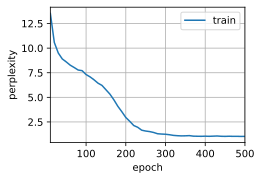

In [38]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

[**最后，让我们检查一下使用随机抽样方法的结果。**]


困惑度 1.3, 64355.2 词元/秒 cuda:0
time travellerit s against reason said filbywhat whal thing be a
travellerit s against reason said filbywhat whal thing be a


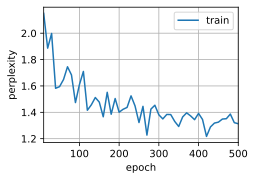

In [16]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

从零开始实现上述循环神经网络模型，虽然有指导意义，但是并不方便。在下一节中，我们将学习如何改进循环神经网络模型，例如，如何使其实现地更容易，运行速度更快。

## 小结

* 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。
* 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。
* 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。
* 当使用顺序划分时，我们需要分离梯度以减少计算量。
* 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐藏状态）。
* 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

## 练习

1. 尝试说明独热编码等价于为每个对象选择不同的嵌入表示。
1. 通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
    * 你能降到多低？
    * 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
    * 它在 H. G. Wells 的其他书作为数据集时效果如何，例如[*星球大战*](http://www.gutenberg.org/ebooks/36)？
1. 修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
    * 会发生什么？
    * 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。
1. 在不裁剪梯度的情况下运行本节中的代码会发生什么？
1. 更改顺序划分，使其不会从计算图中分离隐藏状态。运行时间会有变化吗？困惑度呢？
1. 用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？


# 通过时间反向传播
:label:`sec_bptt`

到目前为止，我们已经反复提到像“梯度爆炸”、“梯度消失”，以及需要对循环神经网络“分离梯度”。
例如，在 :numref:`sec_rnn_scratch` 中，我们在序列上调用了`detach`函数。为了能够快速构建模型并了解其工作原理，上面所说的这些概念都没有得到充分的解释。在本节中，我们将更深入地探讨序列模型反向传播的细节，以及相关的数学原理。

当我们首次实现循环神经网络（ :numref:`sec_rnn_scratch` ）时，遇到了梯度爆炸的问题。如果你做了练习题，就会发现梯度裁剪对于确保模型收敛至关重要。为了更好地理解此问题，本节将回顾序列模型梯度的计算方式，它在工作原理上没有什么新概念，毕竟我们使用的仍然是链式法则来计算梯度。

我们在 :numref:`sec_backprop` 中描述了多层感知机中的前向与反向传播及相关的计算图。循环神经网络中的前向传播相对简单。
*通过时间反向传播*（Backpropagation through time，BPTT） :cite:`Werbos.1990` 实际上是循环神经网络中反向传播技术的一个特定应用。它要求我们将循环神经网络的计算图一次展开一个时间步，以获得模型变量和参数之间的依赖关系。然后，基于链式法则，应用反向传播来计算和存储梯度。由于序列可能相当长，因此依赖关系也可能相当长。例如，某个1000个字符的序列，其第一个词元可能会对最后位置的词元产生重大影响。这在计算上是不可行的（它需要的时间和内存都太多了），并且还需要超过1000个矩阵的乘积才能得到非常难以捉摸的梯度。这个过程充满了计算与统计的不确定性。在下文中，我们将阐明会发生什么以及如何在实践中解决它们。

## 循环神经网络的梯度分析
:label:`subsec_bptt_analysis`

我们从一个描述循环神经网络工作原理的简化模型开始，此模型忽略了隐藏状态的特性及其更新方式的细节。这里的数学表示没有像过去那样明确地区分标量、向量和矩阵，因为这些细节对于分析并不重要，反而只会使本小节中的符号变得混乱。

在这个简化模型中，我们将时间步$t$的隐藏状态表示为$h_t$，输入表示为$x_t$，输出表示为$o_t$。回想一下我们在 :numref:`subsec_rnn_w_hidden_states` 中的讨论，即输入和隐藏状态可以拼接为隐藏层中的一个权重变量。因此，我们分别使用 $w_h$ 和 $w_o$ 来表示隐藏层和输出层的权重。因此，每个时间步的隐藏状态和输出可以写为：

$$\begin{aligned}h_t &= f(x_t, h_{t-1}, w_h),\\o_t &= g(h_t, w_o),\end{aligned}$$
:eqlabel:`eq_bptt_ht_ot`

其中$f$和$g$分别是隐藏层和输出层的变换。因此，我们有一个链$\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$，它们通过循环计算彼此依赖。正向传播相当简单，一次一个时间步的遍历三元组$(x_t, h_t, o_t)$，然后通过一个目标函数在所有 $T$个时间步内评估输出 $o_t$ 和对应的标签 $y_t$ 之间的差异：

$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_h, w_o) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t).$$

对于反向传播，问题则有点棘手，特别是当我们计算目标函数$L$关于参数$w_h$的梯度时。具体来说，按照链式法则：

$$\begin{aligned}\frac{\partial L}{\partial w_h}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_h}  \\& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_o)}{\partial h_t}  \frac{\partial h_t}{\partial w_h}.\end{aligned}$$
:eqlabel:`eq_bptt_partial_L_wh`

在 :eqref:`eq_bptt_partial_L_wh` 中乘积的第一项和第二项很容易计算，而第三项 $\partial h_t/\partial w_h$ 是使事情变得棘手的地方，因为我们需要循环地计算参数 $w_h$ 对 $h_t$ 的影响。根据 :eqref:`eq_bptt_ht_ot` 中的递归计算，$h_t$既依赖于$h_{t-1}$又依赖于$w_h$，其中$h_{t-1}$的计算也依赖于$w_h$。因此，使用链式法则产生：

$$\frac{\partial h_t}{\partial w_h}= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_h}.$$
:eqlabel:`eq_bptt_partial_ht_wh_recur`

为了导出上述梯度，假设我们有三个序列$\{a_{t}\},\{b_{t}\},\{c_{t}\}$，当$t=1,2,\ldots$时序列满足$a_{0}=0$ 且 $a_{t}=b_{t}+c_{t}a_{t-1}$。然后对于 $t\geq 1$，就很容易写出：

$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}.$$
:eqlabel:`eq_bptt_at`

基于下列公式替换$a_t$、$b_t$和$c_t$：

$$\begin{aligned}a_t &= \frac{\partial h_t}{\partial w_h},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}},\end{aligned}$$

公式 :eqref:`eq_bptt_partial_ht_wh_recur` 中的梯度计算满足$a_{t}=b_{t}+c_{t}a_{t-1}$。因此，对于每个 :eqref:`eq_bptt_at`，我们可以使用下面的公式移除 :eqref:`eq_bptt_partial_ht_wh_recur` 中的循环计算

$$\frac{\partial h_t}{\partial w_h}=\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_h)}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_h)}{\partial w_h}.$$
:eqlabel:`eq_bptt_partial_ht_wh_gen`

虽然我们可以使用链式法则递归地计算 $\partial h_t/\partial w_h$，但当 $t$ 很大时这个链就会变得很长。让我们想想办法来处理这一问题.

### 完全计算 ##

显然，我们可以仅仅计算 :eqref:`eq_bptt_partial_ht_wh_gen` 中的全部总和，然而，这样的计算非常缓慢，并且可能会发生梯度爆炸，因为初始条件的微小变化就可能会对结果产生巨大的影响。也就是说，我们可以看到类似于蝴蝶效应的东西，即初始条件的很小变化就会导致结果发生不成比例的变化。这对于我们想要估计的模型而言是非常不可取的。毕竟，我们正在寻找的是能够很好地泛化模型的鲁棒的估计器。因此，在实践中，这种方法几乎从未使用过。

### 截断时间步 ##

或者，我们可以在 $\tau$ 步后截断 :eqref:`eq_bptt_partial_ht_wh_gen` 中的求和计算。这就是我们到目前为止一直在讨论的内容，例如当我们在 :numref:`sec_rnn_scratch` 中分离梯度时。这会带来真实梯度的*近似*，只需将求和终止为$\partial h_{t-\tau}/\partial w_h$。在实践中，这种方式工作得很好。它通常被称为截断的通过时间反向传播 :cite:`Jaeger.2002`。这样做的后果之一是，该模型主要侧重于短期影响，而不是长期影响。这在现实中是可取的，因为它会将估计值偏向更简单和更稳定的模型。

### 随机截断 ##

最后，我们可以用一个随机变量替换$\partial h_t/\partial w_h$，该随机变量在预期中是正确的，但是会截断序列。这个随机变量是通过使用序列$\xi_t$来实现的，序列预定义了$0 \leq \pi_t \leq 1$，其中$P(\xi_t = 0) = 1-\pi_t$ 且$P(\xi_t = \pi_t^{-1}) = \pi_t$，因此 $E[\xi_t] = 1$。我们使用它来替换 :eqref:`eq_bptt_partial_ht_wh_recur` 中的梯度 $\partial h_t/\partial w_h$得：

$$z_t= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\xi_t \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_h}.$$

从$\xi_t$的定义中推导出来$E[z_t] = \partial h_t/\partial w_h$。每当$\xi_t = 0$时，递归计算终止在这个$t$时间步。这导致了不同长度序列的加权和，其中长序列出现的很少，所以将适当地加大权重。这个想法是由塔莱克和奥利维尔 :cite:`Tallec.Ollivier.2017` 提出的。

### 比较策略

![比较RNN中计算梯度的策略。自上而下：随机截断、常规截断、完整计算。](../img/truncated-bptt.svg)
:label:`fig_truncated_bptt`

:numref:`fig_truncated_bptt` 说明了当基于循环神经网络使用通过时间反向传播分析《时间机器》书中前几个字符的三种策略：

* 第一行采用随机截断，方法是将文本划分为不同长度的片断。
* 第二行采用常规截断，方法是将文本分解为相同长度的子序列。这也是我们在循环神经网络实验中一直在做的。
* 第三行采用通过时间的完全反向传播，结果是产生了在计算上不可行的表达式。

遗憾的是，虽然随机截断在理论上具有吸引力，但很可能是由于多种因素在实践中并不比常规截断更好。首先，在对过去若干个时间步经过反向传播后，观测结果足以捕获实际的依赖关系。其次，增加的方差抵消了时间步数越多梯度越精确的事实。第三，我们真正想要的是只有短范围交互的模型。因此，模型需要的正是截断的通过时间反向传播方法所具备的轻度正则化效果。

## 通过时间反向传播的细节

在讨论一般性原则之后，让我们讨论通过时间反向传播问题的细节。与 :numref:`subsec_bptt_analysis` 中的分析不同，下面我们将展示如何计算目标函数相对于所有分解模型参数的梯度。为了保持简单，我们考虑一个没有偏置参数的循环神经网络，其在隐藏层中的激活函数使用恒等映射（$\phi(x)=x$）。对于时间步$t$，设单个样本的输入及其对应的标签分别为$\mathbf{x}_t \in \mathbb{R}^d$和$y_t$。计算隐藏状态$\mathbf{h}_t \in \mathbb{R}^h$和输出$\mathbf{o}_t \in \mathbb{R}^q$的方式为：

$$\begin{aligned}\mathbf{h}_t &= \mathbf{W}_{hx} \mathbf{x}_t + \mathbf{W}_{hh} \mathbf{h}_{t-1},\\
\mathbf{o}_t &= \mathbf{W}_{qh} \mathbf{h}_{t},\end{aligned}$$

其中权重参数为 $\mathbf{W}_{hx} \in \mathbb{R}^{h \times d}$、$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$和
$\mathbf{W}_{qh} \in \mathbb{R}^{q \times h}$。用$l(\mathbf{o}_t, y_t)$表示时间步$t$处的损失函数，则我们的目标函数，即从序列开始起的超过$T$个时间步的总体损失是这样的

$$L = \frac{1}{T} \sum_{t=1}^T l(\mathbf{o}_t, y_t).$$

为了在循环神经网络的计算过程中可视化模型变量和参数之间的依赖关系，我们可以为模型绘制一个计算图，如 :numref:`fig_rnn_bptt` 所示。例如，时间步3的隐藏状态$\mathbf{h}_3$的计算取决于模型参数$\mathbf{W}_{hx}$和$\mathbf{W}_{hh}$，以及最终时间步的隐藏状态$\mathbf{h}_2$以及当前时间步的输入$\mathbf{x}_3$。

![显示具有三个时间步的循环神经网络模型依赖关系的计算图。未着色的方框表示变量，着色的方框表示参数，圆表示运算符。](../img/rnn-bptt.svg)
:label:`fig_rnn_bptt`

正如刚才提到的， :numref:`fig_rnn_bptt` 中的模型参数是$\mathbf{W}_{hx}$、$\mathbf{W}_{hh}$和$\mathbf{W}_{qh}$。通常，训练该模型需要对这些参数进行梯度计算 $\partial L/\partial \mathbf{W}_{hx}$ 、 $\partial L/\partial \mathbf{W}_{hh}$ 和 $\partial L/\partial \mathbf{W}_{qh}$。根据 :numref:`fig_rnn_bptt` 中的依赖关系，我们可以沿箭头的相反方向遍历计算图，依次计算和存储梯度。为了灵活地表示链式法则中不同形状的矩阵、向量和标量的乘法，我们继续使用如 :numref:`sec_backprop` 中所述的 $\text{prod}$ 运算符。

首先，在任意时间步$t$，目标函数关于模型输出的微分计算是相当简单的：

$$\frac{\partial L}{\partial \mathbf{o}_t} =  \frac{\partial l (\mathbf{o}_t, y_t)}{T \cdot \partial \mathbf{o}_t} \in \mathbb{R}^q.$$
:eqlabel:`eq_bptt_partial_L_ot`

现在，我们可以计算目标函数关于输出层中的参数$\mathbf{W}_{qh}$的梯度：$\partial L/\partial \mathbf{W}_{qh} \in \mathbb{R}^{q \times h}$。基于 :numref:`fig_rnn_bptt` ，目标函数$L$通过$\mathbf{o}_1, \ldots, \mathbf{o}_T$依赖于$\mathbf{W}_{qh}$。依据链式法则，得

$$
\frac{\partial L}{\partial \mathbf{W}_{qh}}
= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{W}_{qh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{o}_t} \mathbf{h}_t^\top,
$$

其中$\partial L/\partial \mathbf{o}_t$是由 :eqref:`eq_bptt_partial_L_ot` 给出的。

接下来，如 :numref:`fig_rnn_bptt` 所示，在最后的时间步$T$，目标函数$L$仅通过$\mathbf{o}_T$依赖于隐藏状态$\mathbf{h}_T$。因此，我们通过使用链式法可以很容易地得到梯度$\partial L/\partial \mathbf{h}_T \in \mathbb{R}^h$：

$$\frac{\partial L}{\partial \mathbf{h}_T} = \text{prod}\left(\frac{\partial L}{\partial \mathbf{o}_T}, \frac{\partial \mathbf{o}_T}{\partial \mathbf{h}_T} \right) = \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_T}.$$
:eqlabel:`eq_bptt_partial_L_hT_final_step`

当目标函数$L$通过$\mathbf{h}_{t+1}$和$\mathbf{o}_t$依赖$\mathbf{h}_t$时，对于任意时间步$t < T$来说都变得更加棘手。根据链式法则，隐藏状态的梯度$\partial L/\partial \mathbf{h}_t \in \mathbb{R}^h$在任何时间步骤$t < T$时都可以递归地计算为：

$$\frac{\partial L}{\partial \mathbf{h}_t} = \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_{t+1}}, \frac{\partial \mathbf{h}_{t+1}}{\partial \mathbf{h}_t} \right) + \text{prod}\left(\frac{\partial L}{\partial \mathbf{o}_t}, \frac{\partial \mathbf{o}_t}{\partial \mathbf{h}_t} \right) = \mathbf{W}_{hh}^\top \frac{\partial L}{\partial \mathbf{h}_{t+1}} + \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_t}.$$
:eqlabel:`eq_bptt_partial_L_ht_recur`

为了进行分析，对于任何时间步 $1 \leq t \leq T$ 展开递归计算得

$$\frac{\partial L}{\partial \mathbf{h}_t}= \sum_{i=t}^T {\left(\mathbf{W}_{hh}^\top\right)}^{T-i} \mathbf{W}_{qh}^\top \frac{\partial L}{\partial \mathbf{o}_{T+t-i}}.$$
:eqlabel:`eq_bptt_partial_L_ht`


我们可以从 :eqref:`eq_bptt_partial_L_ht` 中看到，这个简单的线性例子已经展现了长序列模型的一些关键问题：它陷入到 $\mathbf{W}_{hh}^\top$ 的潜在的非常大的幂。在这个幂中，小于1的特征值将会消失，大于1的特征值将会发散。这在数值上是不稳定的，表现形式为梯度消失或梯度爆炸。解决此问题的一种方法是按照计算方便的需要截断时间步长的尺寸，如 :numref:`subsec_bptt_analysis` 中所述。实际上，这种截断是通过在给定数量的时间步之后分离梯度来实现的。稍后，我们将看到更复杂的序列模型（如长短期记忆）如何进一步缓解这一问题。

最后， :numref:`fig_rnn_bptt` 表明了，目标函数$L$通过隐藏状态$\mathbf{h}_1, \ldots, \mathbf{h}_T$依赖于隐藏层中的模型参数$\mathbf{W}_{hx}$和$\mathbf{W}_{hh}$。为了计算有关这些参数的梯度$\partial L / \partial \mathbf{W}_{hx} \in \mathbb{R}^{h \times d}$和$\partial L / \partial \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$，我们应用链式规则得：

$$
\begin{aligned}
\frac{\partial L}{\partial \mathbf{W}_{hx}}
&= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hx}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{x}_t^\top,\\
\frac{\partial L}{\partial \mathbf{W}_{hh}}
&= \sum_{t=1}^T \text{prod}\left(\frac{\partial L}{\partial \mathbf{h}_t}, \frac{\partial \mathbf{h}_t}{\partial \mathbf{W}_{hh}}\right)
= \sum_{t=1}^T \frac{\partial L}{\partial \mathbf{h}_t} \mathbf{h}_{t-1}^\top,
\end{aligned}
$$

其中$\partial L/\partial \mathbf{h}_t$是由 :eqref:`eq_bptt_partial_L_hT_final_step` 和 :eqref:`eq_bptt_partial_L_ht_recur` 递归计算得到的，是影响数值稳定性的关键量。

正如我们在 :numref:`sec_backprop` 中所解释的那样，由于通过时间反向传播是反向传播在循环神经网络中的应用方式，所以训练循环神经网络交替使用前向传播和通过时间反向传播。通过时间的反向传播依次计算并存储上述梯度。具体而言，存储的中间值会被重复使用，以避免重复计算，例如存储 $\partial L/\partial \mathbf{h}_t$，以便在计算 $\partial L / \partial \mathbf{W}_{hx}$ 和 $\partial L / \partial \mathbf{W}_{hh}$ 时使用。

## 小结

* “通过时间反向传播”仅仅适用于反向传播在具有隐藏状态的序列模型。
* 截断是计算方便性和数值稳定性的需要。截断包括：规则截断和随机截断。
* 矩阵的高次幂可能导致神经网络特征值的发散或消失，将以梯度爆炸或梯度消失的形式表现出来。
* 为了计算的效率，“通过时间反向传播”在计算期间会缓存中间值。

## 练习

1. 假设我们拥有一个对称矩阵$\mathbf{M} \in \mathbb{R}^{n \times n}$，其特征值为$\lambda_i$，对应的特征向量是$\mathbf{v}_i$($i = 1, \ldots, n$)。通常情况下，假设特征值的序列顺序为$|\lambda_i| \geq |\lambda_{i+1}|$。
   1. 证明$\mathbf{M}^k$拥有特征值$\lambda_i^k$。
   1. 证明对于一个随机向量$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{M}^k \mathbf{x}$将有较高概率与$\mathbf{M}$的特征向量$\mathbf{v}_1$在一条直线上。形式化这个证明过程。
   1. 上述结果对于循环神经网络中的梯度意味着什么？
1. 除了梯度裁剪，你还能想到其他方法来应对循环神经网络中的梯度爆炸吗？

[Discussions](https://discuss.d2l.ai/t/2107)


[Discussions](https://discuss.d2l.ai/t/2091)
